# Dno Oka (na 4)
TODO:
- add `pipelines`
- add reasonable features (`Hu`, central, colors, etc)

In [2]:
from vessel_util import *
plt.rcParams['figure.figsize'] = (14, 7)

In [3]:
def load_sample_data(sample_name: str):
    image = load_image(sample_name)
    gold_standard = load_gold_standard(sample_name)
    fov_mask = load_fov(sample_name)
    
    return (image, gold_standard, fov_mask)

def plt_show_sample(image, gold_standard, fov_mask):
    plt.subplot(131)
    plt.title("Retinal Fundus")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(132)
    plt.title("Gold standard")
    plt.imshow(gold_standard, cmap='gray', vmin=0, vmax=255)

    plt.subplot(133)
    plt.title("Fov Mask")
    plt.imshow(fov_mask, cmap='gray', vmin=0, vmax=255)
        

# Generowanie zbioru  
- tworzenie wektora cech
- undersampling

In [28]:
from skimage.measure import moments_central, moments_normalized, moments_hu

def generate_tile_centers(image, fov_mask, tile_size, overlapping = False):
    rows, cols, channels = image.shape
    step_size = 1 if overlapping else tile_size 
    for row in range(tile_size//2, rows - tile_size//2, step_size):
        for col in range(tile_size//2, cols - tile_size//2, step_size):
            if fov_mask[row, col] == 0: # or 0 if not
                continue

            yield (row, col)

def extract_tile_features(image, gold_standard, center, tile_size, debug=False):
    # assert fov_mask != 0
    
    row, col = center

    # gold standard is 0 or 255
    y = 1 if gold_standard[row, col] == 255 else 0
    
    row1 = row - tile_size//2
    row2 = row + tile_size//2 + 1
    col1 = col - tile_size//2
    col2 = col + tile_size//2 + 1
    subimage = image[row1:row2, col1:col2 , :]
    # average of colors
    
    # TODO: fix features
    color_avg = np.average(subimage, axis=(0, 1)) / 255


    g = subimage[:, :, 1]
    g = g.astype('float64')
    g /= 255
    mu = moments_central(g)
    nu = moments_normalized(mu)
    hu_moments = moments_hu(nu)

    x = np.hstack((color_avg, hu_moments))
    
    if debug:
        subgs = gold_standard[row1:row2, col1:col2]

        plt.subplot(121)
        plt.title("Image fragment")
        plt.imshow(subimage, vmin=0, vmax=255)
        plt.subplot(122)
        plt.title("Gold Standard fragment")
        plt.imshow(subgs, vmin=0, vmax=255)
    
    return (x, y)
                


In [32]:
TILE_SIZE = 15 # must be odd
assert TILE_SIZE % 2 == 1

N_TEST_IMAGES = 5
N_SAMPLES_PER_IMAGE = 100000
N_SAMPLES = N_TEST_IMAGES * N_SAMPLES_PER_IMAGE

TILE_OVERLAPPING = True

# Processing

Loading test sample: 07_h


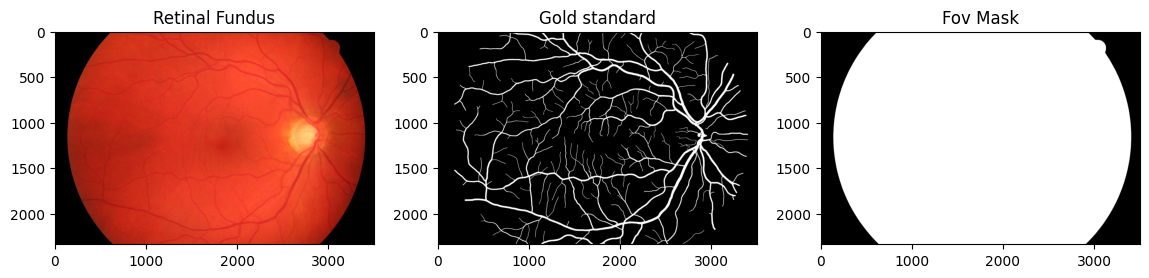

In [33]:
import random

sample_names = get_all_sample_names()

test_samples = random.sample(sample_names, N_TEST_IMAGES)
test_sample = test_samples[0]
print(f"Loading test sample: {test_sample}")

image, gs, fov = load_sample_data(sample_name=test_sample)
plt_show_sample(image, gs, fov)

### Generating sample data

In [34]:
tile_center_coords = list(generate_tile_centers(image=image, fov_mask=fov, overlapping=TILE_OVERLAPPING, tile_size=TILE_SIZE))
test_coords = random.sample(tile_center_coords, N_SAMPLES_PER_IMAGE)

r/c: 267, 2172
values[r,c]: [ 44  63 244], 255
x = array([ 9.61864924e-01,  2.63006536e-01,  1.69742919e-01,  6.42608434e-01,
        9.35160427e-04,  2.25976305e-05,  5.62670061e-06,  6.32126907e-11,
       -7.94104768e-08,  5.44953238e-12])
y = 1


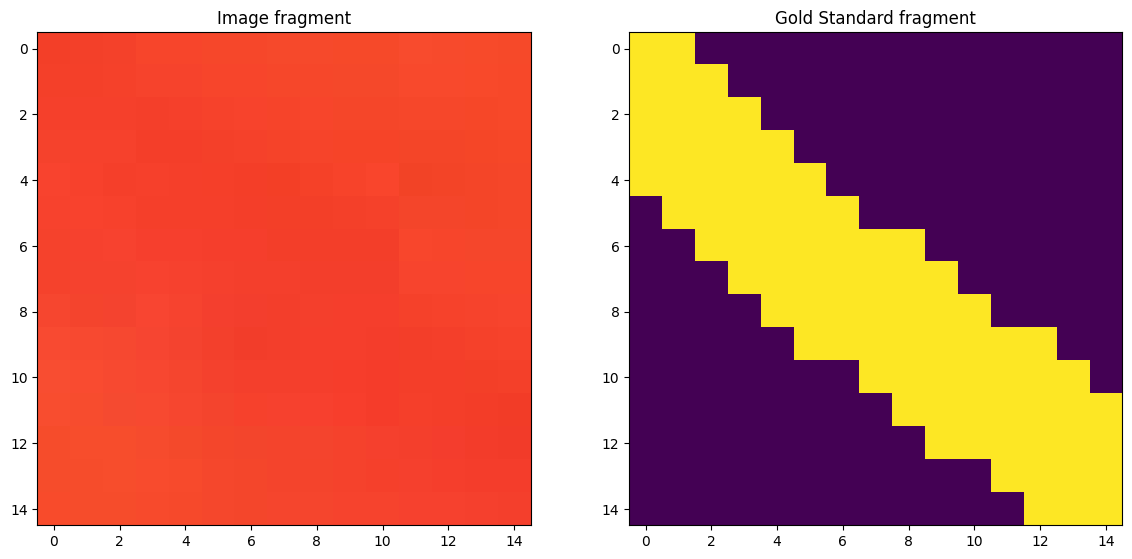

In [35]:
# Example to show where center meets vessel
while True:
    row, col = random.choice(test_coords)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x, y = extract_tile_features(image=image_rgb, gold_standard=gs, center=(row, col), tile_size=TILE_SIZE, debug=False)
    
    if y == 1:
        break

x, y = extract_tile_features(image=image_rgb, gold_standard=gs, center=(row, col), tile_size=TILE_SIZE, debug=True)
print(f"r/c: {row}, {col}")
print(f"values[r,c]: {image[row, col]}, {gs[row, col]}")
print(f"{x = }")
print(f"{y = }")


In [36]:
X = []
y = []
for row, col in test_coords:
    x, decision = extract_tile_features(image=image, gold_standard=gs, center=(row, col), tile_size=TILE_SIZE)
    X.append(x)
    y.append(decision)

print(X[0])
print(y[0])

[1.89647059e-01 2.89010893e-01 9.74675381e-01 5.75670965e-01
 3.13998142e-06 3.15879757e-05 1.44384639e-06 9.73403723e-12
 1.94598208e-09 5.72324876e-13]
0


### Generowanie Zbioru

In [41]:
from tqdm import tqdm

def generate_image_X_y(sample_name: str, tile_size: int, tiles_per_image: int, overlapping: bool, progress_bar: bool = False):
    image, gs, fov = load_sample_data(sample_name)

    tile_center_coords = list(generate_tile_centers(
        image=image, 
        fov_mask=fov, 
        overlapping=overlapping, 
        tile_size=tile_size
    ))

    test_coords = random.sample(tile_center_coords, tiles_per_image)

    X = []
    y = []

    if progress_bar:
        for i, (row, col) in enumerate(tqdm(test_coords)):
            x, decision = extract_tile_features(image=image, gold_standard=gs, center=(row, col), tile_size=tile_size)
            X.append(x)
            y.append(decision)
    else:
        for row, col in test_coords:
            x, decision = extract_tile_features(image=image, gold_standard=gs, center=(row, col), tile_size=tile_size)
            X.append(x)
            y.append(decision)
    return (X, y)
    
def bulk_generate_X_y(sample_names: List[str], tile_size: int, tiles_per_image: int, overlapping: bool, progress_bar: bool = False):
    X = []
    y = []
    for sample_name in sample_names:
        new_X, new_y = generate_image_X_y(sample_name, tile_size, tiles_per_image, overlapping, progress_bar)
        X.extend(new_X)
        y.extend(new_y)
    return (X, y)
        


In [42]:
TILE_SIZE = 15 # must be odd
assert TILE_SIZE % 2 == 1

N_TEST_IMAGES = 5
N_SAMPLES_PER_IMAGE = 100000
N_SAMPLES = N_TEST_IMAGES * N_SAMPLES_PER_IMAGE
TILE_OVERLAPPING = True

test_samples = random.sample(sample_names, N_TEST_IMAGES)
print(test_samples)
X, y = bulk_generate_X_y(test_samples, TILE_SIZE, N_SAMPLES_PER_IMAGE, TILE_OVERLAPPING, progress_bar=True)

100%|██████████| 100000/100000 [00:18<00:00, 5482.85it/s]


In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# TODO: co to stratified sampling? i jak to tutaj zrobić?

## Undersampling

In [44]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

rus = RandomUnderSampler(random_state=42)

print(f"Classes counts: {Counter(y)}")

X_res, y_res = rus.fit_resample(X, y)
print(f"After sampling: {Counter(y_res)}")


Classes counts: Counter({0: 454342, 1: 45658})
After sampling: Counter({0: 45658, 1: 45658})


## Support Vector Machine

In [45]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_res, y_res)
y_pred = svc.predict(X_test)

In [46]:
from sklearn.metrics import classification_report

cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.95      0.90      0.93    136372
           1       0.36      0.57      0.44     13628

    accuracy                           0.87    150000
   macro avg       0.66      0.73      0.68    150000
weighted avg       0.90      0.87      0.88    150000



## Dla całego zdjęcia

In [47]:
test_sample = sample_names[-1] 
image, gs, fov = load_sample_data(test_sample)

In [48]:
from tqdm import tqdm
print("...Generating tile centers")
tile_center_coords = list(generate_tile_centers(image=image, fov_mask=fov, overlapping=True, tile_size=TILE_SIZE))
print("...Extracting tile features")

test_image_features = []
for i, (row, col) in enumerate(tqdm(tile_center_coords)):
    x, _ = extract_tile_features(image=image, gold_standard=gs, center=(row, col), tile_size=TILE_SIZE)
    test_image_features.append(x)

...Generating tile centers
...Extracting tile features


100%|██████████| 6880834/6880834 [22:44<00:00, 5042.84it/s]


In [49]:
print("...Using classifier")
classifier = svc
test_image_predictions = classifier.predict(test_image_features)

...Using classifier


In [24]:
print(f"...Making mask from predicitons {Counter(test_image_predictions)}")
mask = np.zeros_like(fov)
# mask = np.where(test_image_predictions == 1, mask, 255)
for i, (row, col) in enumerate(tqdm(tile_center_coords)):
    if test_image_predictions[i]: mask[row, col] = 255


...Making mask from predicitons Counter({0: 6876948, 1: 3886})


100%|██████████| 6880834/6880834 [00:02<00:00, 2430141.51it/s]


...Comparing gold standard to mask
Accuracy: 97.79%
Sensitivity: 100.00%
Specificity: 0.59%
Mean(spec, sens): 50.30%
GeoMean(spec, sens): 7.70%


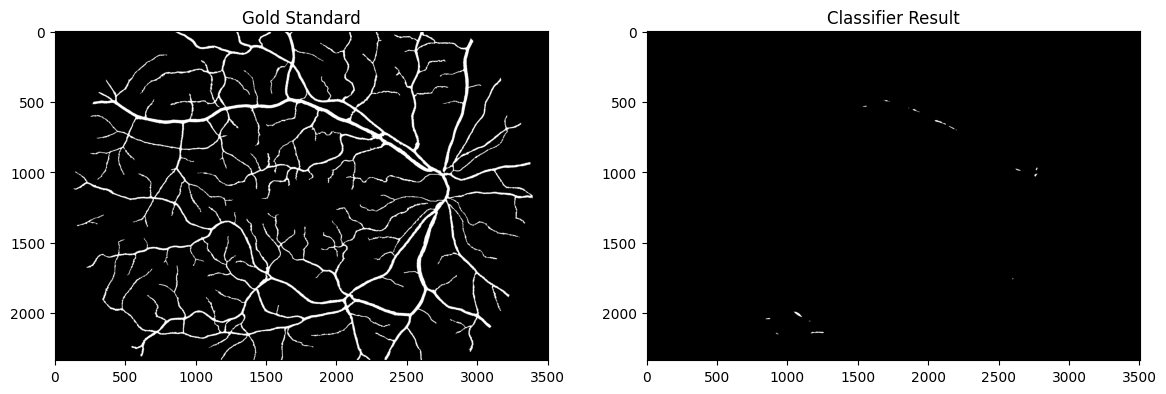

In [27]:
print("...Comparing gold standard to mask")
plt_compare_two_images(gs, mask, grayscale=True, title1="Gold Standard", title2="Classifier Result")
print_statistics(gs, mask)